In this notebook, we illustrate a couple of transfer learning approaches for CNN networks.

In [1]:
%tensorflow_version 2.x

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import tensorflow.keras.applications.vgg16 as vgg16
import tensorflow.keras.applications.resnet50 as resnet50
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from glob import iglob

We're going to work with the car accident image data set found [here](http://norc.aut.ac.ir/its-data-repository/accident-images-analysis-dataset/). First, let's download and unpack the data.

In [2]:
!wget http://mg.bluecourses.com/wp-content/uploads/2020/04/car.rar -O data.rar

--2020-07-22 08:42:46--  http://mg.bluecourses.com/wp-content/uploads/2020/04/car.rar
Resolving mg.bluecourses.com (mg.bluecourses.com)... 46.30.215.75
Connecting to mg.bluecourses.com (mg.bluecourses.com)|46.30.215.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1409024 (1.3M) [application/rar]
Saving to: ‘data.rar’

data.rar            100%[===================>]   1.34M   808KB/s    in 1.7s    

2020-07-22 08:42:49 (808 KB/s) - ‘data.rar’ saved [1409024/1409024]



In [3]:
!unrar x -o+ -y -inul data.rar

Let's take a look at an example. The pictures are drastically downscaled, which is a bit of pity. If anything, it'll be a wonder our CNN will be able to classify these.

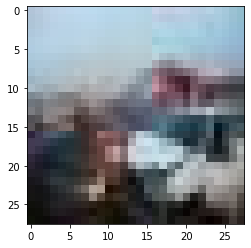

In [ ]:
example = image.load_img('Accident Images Analysis Dataset/Accident -Detection/2/1789.jpg')
plt.imshow(example)
plt.show()

We're going to prepare our images using a helper function which will create `X` and `y` arrays for us.

One important thing we need to take care of is to preprocess our images according to what our neural network expects. For VGG16, the first network we'll use, it expects images to be in a certain size and normalized. As such, we allow to pass in a `preprocessor` function.

In [ ]:
basepath = 'Accident Images Analysis Dataset/'

def prepare_images(path, num_classes, preprocessor, load_img_kwargs={}, ext='.jpg'):
  X, y = [], []
  for class_ in range(num_classes):
    for img_path in iglob(path + str(class_ + 1) + '/' + '*' + ext):
      img = image.load_img(img_path, **load_img_kwargs)
      x = image.img_to_array(img)
      x = preprocessor(x)
      X.append(x)
      y.append(class_)
  return np.array(X), np.array(y)

In [ ]:
X, y = prepare_images(basepath + 'Accident -Detection/', 2, vgg16.preprocess_input, load_img_kwargs={'target_size': (224, 224)})
y_cat = to_categorical(y)

len(X), len(y), np.unique(y)

(4898, 4898, array([0, 1]))

This looks good. Let's now load in the pretrained network. The `weights` arguments specifies that we want to load in the pretrained weights, not just the architecture. `include_top` specifies that we want to include the last layer.

In [ ]:
model = vgg16.VGG16(weights='imagenet', include_top=True)

553467904/553467096 [==============================] - 12s 0us/step


Let's see what our model thinks of the first image:

In [ ]:
output = model.predict(np.expand_dims(X[0], axis=0))
output.shape

(1, 1000)

The pretrained model has been trained on 1000 classes, whereas we only need two classes here. The first way to solve this is to just regard our model as a feature extractor, and use the final 1000-long probability vector as features which can be used by another model. Let's try this out:

In [ ]:
output = model.predict(X)
output.shape

(4898, 1000)

Note that `output` will serve as the input instances for the following model.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(output, y_cat, test_size=0.25)

Next, we set up our "model on top". We're going to create a simple fully connected stack here.

In [ ]:
modelontop = Sequential()
modelontop.add(Dense(512, input_dim=1000, activation='relu'))
modelontop.add(Dropout(0.25))
modelontop.add(Dense(128, activation='relu'))
modelontop.add(Dropout(0.25))
modelontop.add(Dense(64, activation='relu'))
modelontop.add(Dropout(0.25))
modelontop.add(Dense(2, activation='softmax'))
modelontop.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelontop.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               512512    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1

Let's train this network for 100 epochs:

In [ ]:
batch_size = 128
epochs     = 100

hist = modelontop.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          verbose=0)

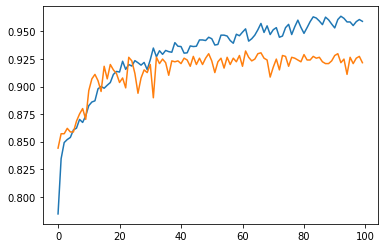

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

This is not too bad, we obtain a good accuracy on the test set using this simple setup, but let's see if we can do better.

For our second example, let's switch to a different model: Resnet50.

In [ ]:
model = resnet50.ResNet50(weights='imagenet', include_top=False)
model.output

94773248/94765736 [==============================] - 3s 0us/step


<tf.Tensor 'conv5_block3_out/Identity:0' shape=(None, None, None, 2048) dtype=float32>

As you can see, this model is pretty versatile. We have chosen not to include the final layer. Since this model is a FCN (fully convolutional network), the shape of the final output is now `(None, None, None, 2048)` -- this means this network is agnostic to the number of instances we pass in, the width, and the height, and will simply give back 2048 filters at the end.

We can directly use these filters to add some layers on top. Here, the style how we do so is by using the Keras functional API. Instead of adding layers to a Sequential model as we did so far, we now utilize each layer we create as a function which can be called with the previous layer as the input.

Basically, the only thing we need to do here is use global average pooling. We also add some dense layers on top to reflow the 2048 features to 2 output neurons.

Note: at this point, since we only have two class outcomes and are dealing with binary classification, you might be wondering whether we couldn't simply use one neuron instead with a different loss function. Indeed we can -- try this out if you want!

In [ ]:
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(2, activation='softmax')(x)

fullmodel = Model(inputs=model.input, outputs=predictions)

We don't want to waste time to retrain the full network (which is pretty large). From what we know of CNNs, we know that the lower-level convolutional layers focus on feature extraction, so it is likely these filters can simply be reused with their weights as is. Instead, we're going to set *all* layers in the original network to be non-trainable (this is also oftentimes refered to as freezing the layers), so that only the layers we've added on top will be trainable.

Note: this won't always be that easy. Depending on how different your images look from the images the network was trained on, you might need to "unfreeze" more layers. A good idea is to start from bottom to top and see how many you need to unfreeze.

In [ ]:
for layer in model.layers:
    layer.trainable = False

fullmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

We then train again on our instances, now using the original images as inputs, of course, and not the 1000-sized output vector we used before.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.25)

Let's make it challenging and only train for 3 epochs here.

In [ ]:
batch_size = 32
epochs     = 3

hist = fullmodel.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          verbose=2)

Epoch 1/3
115/115 - 10s - loss: 0.4989 - accuracy: 0.8715 - val_loss: 0.1664 - val_accuracy: 0.9371
Epoch 2/3
115/115 - 8s - loss: 0.1492 - accuracy: 0.9417 - val_loss: 0.1445 - val_accuracy: 0.9396
Epoch 3/3
115/115 - 8s - loss: 0.1234 - accuracy: 0.9545 - val_loss: 0.1247 - val_accuracy: 0.9494


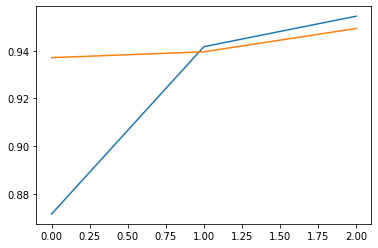

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

With a minimal amount of effort and just a couple seconds of fine-tuning, we already get a better test set result as what we'd gotten earlier.